<a href="https://colab.research.google.com/github/laughingbud/conquer/blob/main/MScFE622_GP1_DV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Modelling Group Project 1
# Student Group 3587

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.fft import fft
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import brute, fmin

In [ ]:
!git clone https://github.com/laughingbud/conquer.git # clone github repo

fatal: destination path 'conquer' already exists and is not an empty directory.


#Section 1. Prepare Market Data

In [ ]:
# options = pd.read_excel("MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx")
options = pd.read_excel("conquer/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx")
S0 = 232.90 # SM stock is currently trading at $232.90 USD

In [ ]:
# Adding Time-to-Maturity and constant short-rates
for row, option in options.iterrows():
    T = option["Days to maturity"] / 250.0 #Assume 1 year has 250 trading days.
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.015 #constant annual risk-free rate of 1.50%

In [ ]:
# options with short maturity = 15 days
options_short_mat = options[options['Days to maturity'] == 15]

In [ ]:
options_short_mat.head(5)

,Days to maturity,Strike,Price,Type,T,r
0,15,227.5,10.52,C,0.06,0.015
1,15,230.0,10.05,C,0.06,0.015
2,15,232.5,7.75,C,0.06,0.015
3,15,235.0,6.01,C,0.06,0.015
4,15,237.5,4.75,C,0.06,0.015


In [ ]:
# options with long maturity = 60 days
options_long_mat = options[options['Days to maturity'] == 60]

In [ ]:
options_long_mat.head(5)

,Days to maturity,Strike,Price,Type,T,r
5,60,227.5,16.78,C,0.24,0.015
6,60,230.0,17.65,C,0.24,0.015
7,60,232.5,16.86,C,0.24,0.015
8,60,235.0,16.05,C,0.24,0.015
9,60,237.5,15.10,C,0.24,0.015


#Section 2. Functions for Heston (1993) model pricing and calibration

In [ ]:
i = 0
min_MSE = 500
local_opt = False

In [ ]:
def H93_calibration(error_func):
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        error_func,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01), # v0
        ),
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        error_func, p0, xtol=0.000001, ftol=0.000001, maxiter=950, maxfun=900
    )
    return opt

In [ ]:
def H93_error_lewis(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options_short_mat.iterrows():
        model_value = H93_price_lewis(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            option["Type"],
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def H93_price_lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, type):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    if type == "C":
      return call_value
    else:
      put_value = call_value + K * np.exp(-r * T) - S0
      return put_value

In [ ]:
def H93_error_carrM(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options_short_mat.iterrows():
        model_value = H93_price_carrM(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            option["Type"],
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def H93_price_carrM(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, type):
    """European Call option price in BS under FFT"""

    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    if type == "C":
      return CallValue
    else:
      put_value = CallValue + K * np.exp(-r * T) - S0
      return put_value

In [ ]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def H93_calculate_model_values(p0, price_func, option_df):
    """Calculates all model values given parameter vector p0."""
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in option_df.iterrows():
        model_value = price_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            option["Type"],
        )
        values.append(model_value)
    return np.array(values)

In [ ]:
def plot_calibration_results(p0, calculate_model_func, price_func, option_df):
    modelValue = calculate_model_func(p0, price_func, option_df)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Days to maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(option_df.Strike, option_df.Price, "b", label="market")
    plt.plot(option_df.Strike, modelValue, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(option_df.Strike) - 10,
            max(option_df.Strike) + 10,
            min(option_df.Price) - 10,
            max(option_df.Price) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = modelValue - option_df.Price
    plt.bar(option_df.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(option_df.Strike) - 10,
            max(option_df.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

#Section 3 Heston (1993) Model Calibration
##Step 1
##a. Calibrate Heston (1993) model without jumps using Lewis approach and options with maturisy = 15 days

In [ ]:
params_hesten_lewis = H93_calibration(H93_error_lewis)

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  20.086 |  20.086
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  12.679 |   8.761
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |   9.815 |   8.759
 300 | [ 7.10037179  0.05742843  0.11352214 -0.46596154  0.04611934] |   4.121 |   4.121
 400 | [5.50586718e+00 1.19665034e-01 1.04253404e-04 5.11531255e-01
 9.02377801e-02] |   0.345 |   0.345


<ipython-input-150-13f4e917971b>:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(
<ipython-input-150-13f4e917971b>:29: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(


 500 | [5.53737560e+00 1.19801898e-01 6.30401694e-06 5.16620087e-01
 9.02583148e-02] |   0.345 |   0.345
 600 | [5.53755436e+00 1.19802387e-01 6.28028326e-06 5.16645131e-01
 9.02583180e-02] |   0.345 |   0.345
 700 | [5.53755409e+00 1.19802387e-01 6.28013183e-06 5.16645086e-01
 9.02583177e-02] |   0.345 |   0.345
 800 | [5.53755409e+00 1.19802387e-01 6.28013179e-06 5.16645086e-01
 9.02583177e-02] |   0.345 |   0.345
Optimization terminated successfully.
         Current function value: 0.344513
         Iterations: 305
         Function evaluations: 668


<ipython-input-150-13f4e917971b>:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


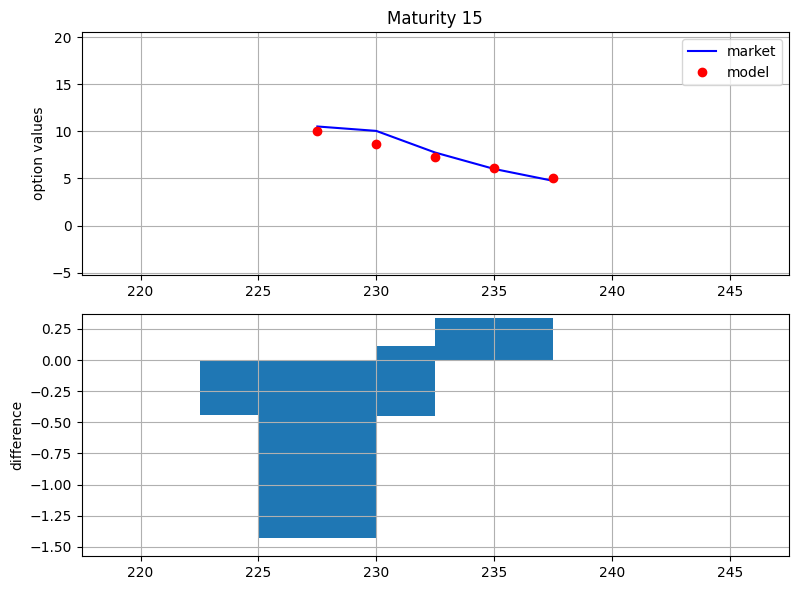

In [ ]:
# Use call options market price with maturity = 15 days to observe model fitness
options_short_call = options_short_mat[options_short_mat["Type"] == "C"]
plot_calibration_results(params_hesten_lewis, H93_calculate_model_values, H93_price_lewis,options_short_call)

##b. Calibrate Heston (1993) model without jumps using Carr-Madan approach and options with maturisy = 15 days

In [ ]:
params_hesten_carrM = H93_calibration(H93_error_carrM)

 900 | [ 2.5   0.01  0.05 -0.75  0.03] |  16.785 |   0.345
1000 | [ 2.5   0.04  0.05 -0.25  0.01] |   2.583 |   0.345
1100 | [7.5  0.02 0.25 0.   0.02] |   8.420 |   0.345
1200 | [7.76419381e+00 1.02482158e-02 2.78612910e-01 3.53472089e-04
 7.28349570e-03] |   0.535 |   0.345
1300 | [7.97059205e+00 1.03206934e-02 2.83318062e-01 1.55822286e-04
 6.81259690e-03] |   0.520 |   0.345
1400 | [ 1.23306206e+01  3.17390587e-02  6.67230480e-01 -2.72797706e-02
 -1.72529141e-03] |   0.511 |   0.345
1500 | [ 1.56439862e+01  4.90191111e-02  1.01469677e+00 -4.65861975e-02
 -1.47860278e-02] |   0.502 |   0.345
1600 | [18.09054645  0.07293263  1.53376687 -0.07104497 -0.03705112] |   0.490 |   0.345
1700 | [18.87836976  0.08402513  1.78115538 -0.08197249 -0.0481118 ] |   0.483 |   0.345
1800 | [18.87955662  0.08402465  1.78120529 -0.08197812 -0.0481195 ] |   0.483 |   0.345
1900 | [21.26561113  0.08838845  1.93866027 -0.09436451 -0.06086602] |   0.480 |   0.345


<ipython-input-148-ac197eebb5c7>:19: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


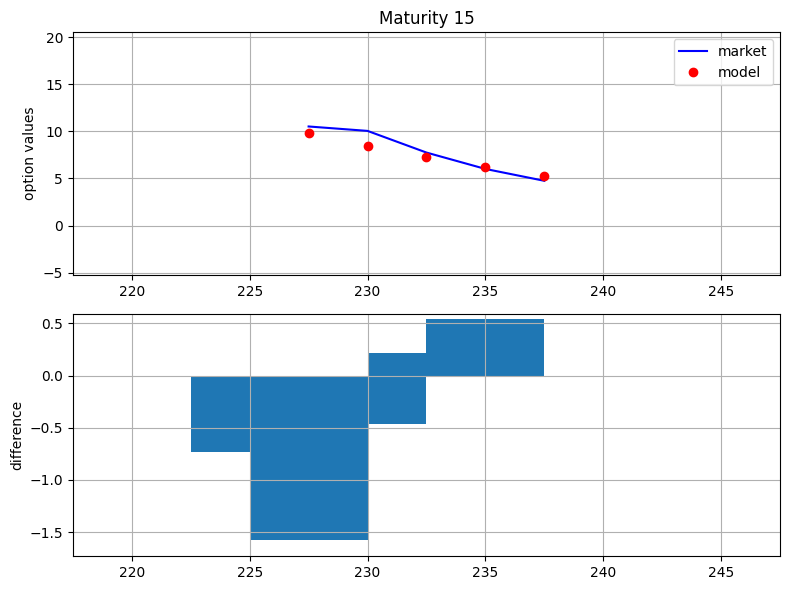

In [ ]:
plot_calibration_results(params_hesten_carrM, H93_calculate_model_values, H93_price_carrM, options_short_call)

## c. Price Asian option using Monte Carlo

#Section 4. Functions for Bates (1996) model pricing and calibration
##a. Functions for calibration of the jump component

In [ ]:
# get parameters from calibration of the Heston (1993) model
kappa_v, theta_v, sigma_v, rho, v0 = params_hesten_lewis

In [ ]:
def B96_calibration_jump(erro_func):
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        erro_func,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25), # delta
        ),
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        erro_func,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [ ]:
def B96_error_lewis(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_long_mat.iterrows():
        model_value = B96_price_lewis(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            option["Type"],
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [ ]:
def B96_price_lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, type):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    if type == "C":
      return call_value
    else:
      put_value = call_value + K * np.exp(-r * T) - S0
      return put_value

In [ ]:
def B96_error_carrM(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_long_mat.iterrows():
        model_value = B96_price_carrM(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            option["Type"],
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [ ]:
def B96_price_carrM(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, type):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    if type == "C":
      return CallValue
    else:
      put_value = CallValue + K * np.exp(-r * T) - S0
      return put_value

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

## b. Functions for full Calibration of Bates model

In [ ]:
# get parameters from calibration of the jump component using Levis approach
lamb_lewis, mu_lewis, delta_lewis = B96_calibration_jump(B96_error_lewis)
p0_lewis = [kappa_v, theta_v, sigma_v, rho, v0, lamb_lewis, mu_lewis, delta_lewis]

<ipython-input-165-10e51cfecfa2>:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


1950 | [ 0.  -0.5  0.5] |   1.616 |   0.345
1975 | [ 0.2 -0.4  0. ] |   2.617 |   0.345
2000 | [ 0.4  -0.4   0.25] |   7.200 |   0.345
2025 | [ 1.03888889e-01 -2.07777778e-01  8.33333333e-05] |   1.547 |   0.345
2050 | [ 0.16281093 -0.14840649  0.00141444] |   1.547 |   0.345
2075 | [ 0.36229509 -0.10837631  0.00583842] |   1.543 |   0.345
2100 | [ 0.54631675 -0.09149361  0.00976548] |   1.543 |   0.345
2125 | [ 0.85590646 -0.06712433  0.0153343 ] |   1.542 |   0.345
2150 | [ 1.28605573 -0.05202088  0.02176123] |   1.541 |   0.345
2175 | [ 2.20843894 -0.02641498  0.03433976] |   1.541 |   0.345
2200 | [ 2.68768392 -0.00838038  0.04081616] |   1.541 |   0.345
2225 | [ 2.62350785e+00 -7.59267866e-04  3.97073734e-02] |   1.538 |   0.345
2250 | [ 2.61295110e+00 -1.51476882e-05  3.95405040e-02] |   1.538 |   0.345
2275 | [ 2.61239070e+00 -1.03435618e-07  3.95317762e-02] |   1.538 |   0.345
2300 | [ 2.61249382e+00 -3.86471623e-09  3.95332104e-02] |   1.538 |   0.345
2325 | [ 2.61261108e+00 -

In [ ]:
# get parameters from calibration of the jump component using Carr-Madan approach
lamb_carrM, mu_carrM, delta_carrM = B96_calibration_jump(B96_error_carrM)
p0_carrM = [kappa_v, theta_v, sigma_v, rho, v0, lamb_carrM, mu_carrM, delta_carrM]

2400 | [ 0.1 -0.4  0. ] |   1.701 |   0.345
2425 | [ 0.3  -0.4   0.25] |   4.481 |   0.345
2450 | [ 0.5 -0.4  0.5] |  17.664 |   0.345
2475 | [ 1.12186643e-01 -2.04023491e-01  1.64030350e-04] |   1.547 |   0.345
2500 | [ 0.19496879 -0.14840149  0.00210398] |   1.545 |   0.345
2525 | [ 0.38676849 -0.10333068  0.00644864] |   1.543 |   0.345
2550 | [ 0.72748938 -0.07324395  0.01507234] |   1.542 |   0.345
2575 | [ 1.12475313 -0.05602858  0.02503058] |   1.542 |   0.345
2600 | [ 1.19643011 -0.05191422  0.02680094] |   1.542 |   0.345
2625 | [ 1.6247741  -0.03551502  0.03617748] |   1.542 |   0.345
2650 | [ 1.76912307 -0.02977875  0.03942433] |   1.541 |   0.345
2675 | [ 1.7474476  -0.02141192  0.0435519 ] |   1.541 |   0.345
2700 | [ 1.48533803e+00 -7.61908697e-04  5.27281296e-02] |   1.538 |   0.345
2725 | [ 1.46975178e+00 -3.12649923e-06  5.30184038e-02] |   1.538 |   0.345
2750 | [ 1.46890221e+00 -7.69497259e-08  5.30161780e-02] |   1.538 |   0.345
2775 | [ 1.46839339e+00 -3.30248825e-

In [ ]:
from pandas.compat import PY310
def B96_calibration_full(p0, error_func):
    opt = fmin(
        error_func, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [ ]:
i = 0
min_MSE = 5000.0

def B96_error_lewis_full(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_long_mat.iterrows():
        model_value = B96_price_lewis(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            option["Type"],
        )
        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_error_carrM_full(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_long_mat.iterrows():
        model_value = B96_price_carrM(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            option["Type"],
        )
        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_calculate_model_values(p0, price_func, option_df):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

# Section 5 Bates Model Calibration
##Step 2
##a. Calibrate Bates model using Lewis approach and options with maturisy = 60 days

In [ ]:
params_bates_lewis = B96_calibration_full(p0_lewis, B96_error_lewis_full)

<ipython-input-165-10e51cfecfa2>:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


   0 | [ 5.53755409e+00  1.19802387e-01  6.28013179e-06  5.16645086e-01
  9.02583177e-02  2.61263229e+00 -2.46310768e-14  3.95351247e-02] |   1.538 |   1.538
  25 | [ 5.49955534e+00  1.20426146e-01  6.34260071e-06  5.21784192e-01
  9.00097868e-02  2.63862033e+00 -2.48760839e-14  3.97198974e-02] |   1.538 |   1.538
  50 | [ 5.51417246e+00  1.19811946e-01  6.49469330e-06  5.34296332e-01
  9.01152506e-02  2.61363648e+00 -2.39331584e-14  3.99031095e-02] |   1.538 |   1.538
  75 | [ 5.51915386e+00  1.19808083e-01  6.38650956e-06  5.33115828e-01
  9.01780406e-02  2.61166312e+00 -2.47139686e-14  3.97768704e-02] |   1.538 |   1.538
 100 | [ 5.52240500e+00  1.19840324e-01  6.40867525e-06  5.28967888e-01
  9.01521680e-02  2.61520168e+00 -2.45779715e-14  3.97797217e-02] |   1.538 |   1.538
 125 | [ 5.52085272e+00  1.19847903e-01  6.43309433e-06  5.30295639e-01
  9.01438290e-02  2.61414381e+00 -2.44130022e-14  3.98031740e-02] |   1.538 |   1.538
Optimization terminated successfully.
         Curre

In [ ]:
# Use call options market price with maturity = 60 days to observe model fitness
options_long_mat = options_long_mat[options_long_mat["Type"] == "C"]
plot_calibration_results(params_bates_lewis, B96_price_lewis,options_long_mat)

ValueError: ignored

##b. Calibrate Bates model using Carr-Madan approach and options with maturisy = 60 days

In [ ]:
params_bates_carrM = B96_calibration_full(p0_carrM, B96_error_carrM_full)

 150 | [ 5.53755409e+00  1.19802387e-01  6.28013179e-06  5.16645086e-01
  9.02583177e-02  1.46847144e+00 -2.36321864e-14  5.30144792e-02] |   1.538 |   1.538
 175 | [ 5.55860247e+00  1.19084212e-01  6.36006480e-06  5.23220903e-01
  9.03956332e-02  1.45618645e+00 -2.27933095e-14  5.34452975e-02] |   1.538 |   1.538
 200 | [ 5.51715119e+00  1.19799589e-01  5.78842322e-06  5.37545499e-01
  9.01568539e-02  1.47116221e+00 -2.34173384e-14  5.35410824e-02] |   1.538 |   1.538
 225 | [ 5.51314810e+00  1.19780764e-01  5.86870616e-06  5.32448416e-01
  9.01158878e-02  1.47171169e+00 -2.33102326e-14  5.37871327e-02] |   1.538 |   1.538
 250 | [ 5.51057998e+00  1.19798407e-01  5.90064241e-06  5.31641397e-01
  9.01138716e-02  1.47140957e+00 -2.32331280e-14  5.37560373e-02] |   1.538 |   1.538
 275 | [ 5.51039449e+00  1.19796768e-01  5.88473543e-06  5.33542316e-01
  9.01128968e-02  1.47137724e+00 -2.31576227e-14  5.37762051e-02] |   1.538 |   1.538
Optimization terminated successfully.
         Curre

In [ ]:
plot_calibration_results(params_bates_carrM, B96_price_carrM,options_long_mat)